## Samplers demo

En este cuaderno se ilustra el proceso de generación de imágenes sintéticas a color a partir de ruido gaussiano, utilizando diferentes esquemas de muestreo aplicados sobre modelos generativos basados en procesos de difusión de Ornstein-Uhlenbeck (VP).

### Librerias ###

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from functools import partial

import torch
from torch.utils.data import (
    DataLoader,
    Dataset,
    Subset,
)
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import functional

from noise_schedules import LinearSchedule
from torchvision import transforms
from utils.data_loader import load_dataset

from utils import (
    plot_image_grid,
    load_dataset,
    plot_image_grid_color,
    plot_image_evolution_color,
    sample_initial_latents,
)

from samplers import predictor_corrector_integrator, euler_maruyama_integrator, euler_ode_integrator, exponential_integrator
from diffusion import VPProcess


n_threads = torch.get_num_threads()
print('Number of threads: {:d}'.format(n_threads))

device ='cuda'

Number of threads: 12


### Carga de datos

In [2]:
def colorize_grayscale(tensor_img):
    if tensor_img.shape[0] == 1:
        r, g, b = [torch.rand(1).item() for _ in range(3)]
        return torch.cat([tensor_img * r, tensor_img * g, tensor_img * b], dim=0)
    return tensor_img

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(colorize_grayscale),
])

data= load_dataset("mnist", transform=transform, return_loader=False)

In [3]:
# Create a subset dataset composed of only images of one of the digits
digit = 3
indices_digit = torch.where(data.targets == digit)[0]

data_train = Subset(data, indices_digit)

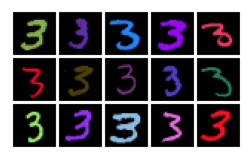

In [4]:
# Visualize training images
n_rows = 3
n_cols = 5

_ = plot_image_grid(
    images=[data_train[i][0] for i in range(n_rows * n_cols)],
    figsize =(3, 3),
    n_rows=n_rows,
    n_cols=n_cols,
)

### Definción del proceso

In [5]:
schedule = LinearSchedule(beta_min=0.01, beta_max=5.0)
diffusion_process= VPProcess(noise_schedule=schedule, use_precomputed_sigma=False)

### Entrenamiento del modelo

In [6]:
from score_models import ScoreNet
from score_models import ScoreNet32

# Crear el score model usando el sigma_t del VEProcess
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)

)
score_model = score_model.to(device)

In [7]:
# Train model

from torch.optim import Adam
import torchvision.transforms as transforms
from tqdm.notebook import trange

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)


learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  50
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

  0%|          | 0/50 [00:00<?, ?it/s]

### Euler maruyama

In [8]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=1,
    device=torch.device("cuda")
)
T_tensor = torch.tensor([T], device=device)

with torch.no_grad():
    times, synthetic_images_t = euler_maruyama_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
   )

print(type(synthetic_images_t))
print(synthetic_images_t.shape)

<class 'torch.Tensor'>
torch.Size([5, 3, 28, 28, 2001])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5620575..3.8927298].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.740538..3.804693].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6217558..3.436827].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1086404..4.1088376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3460202..4.0515275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.973545..3.4525177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8998208..3

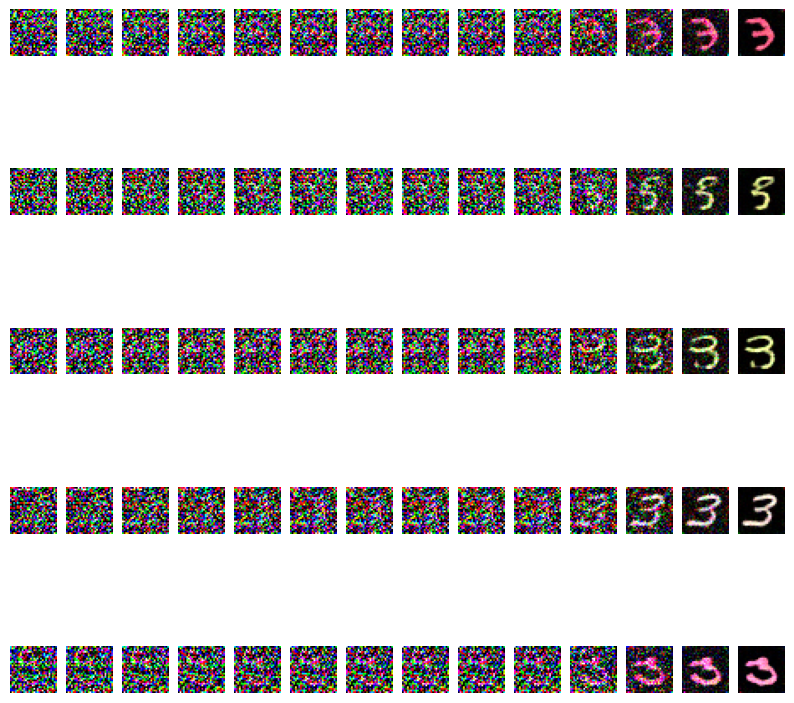

In [9]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

### Ode integrator

In [20]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=1,
    device=torch.device("cuda")
)
T_tensor = torch.tensor([T], device=device)

with torch.no_grad():
    times, synthetic_images_t = euler_ode_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
   )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.1301894..4.5041857].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.1156497..4.473634].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5599082..3.3988366].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3480422..2.9319835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2635868..2.5152476].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2156115..2.3247993].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1948571

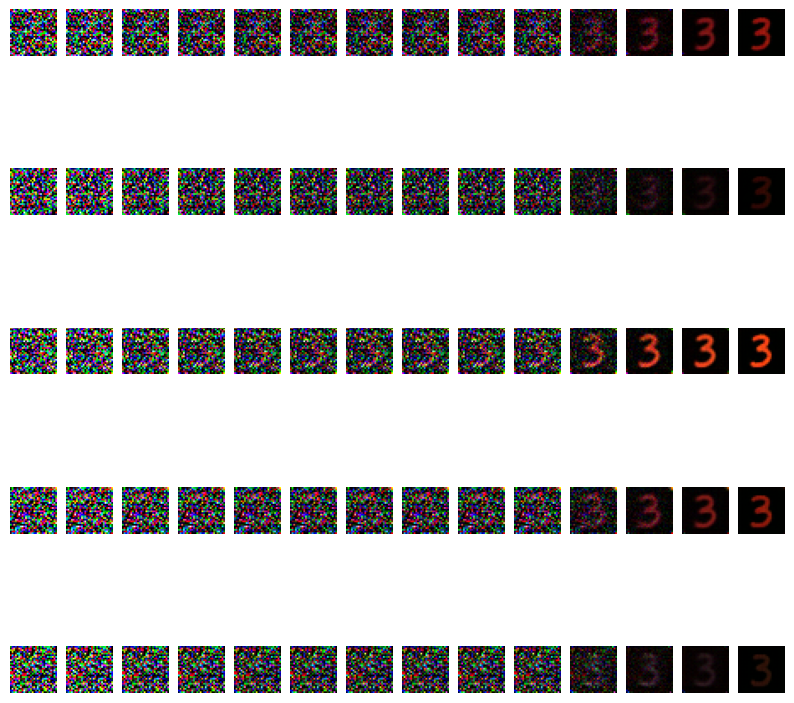

In [21]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

### Predictor corrector

In [22]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=1,
    device=torch.device("cuda")
)
T_tensor = torch.tensor([T], device=device)

with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=5,
        corrector_step_size=0.0001
   )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.514156..4.1497583].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5252204..4.33552].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.949081..3.5604742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6432247..3.2157621].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8561456..3.2378542].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9653218..3.0225546].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7888255..3

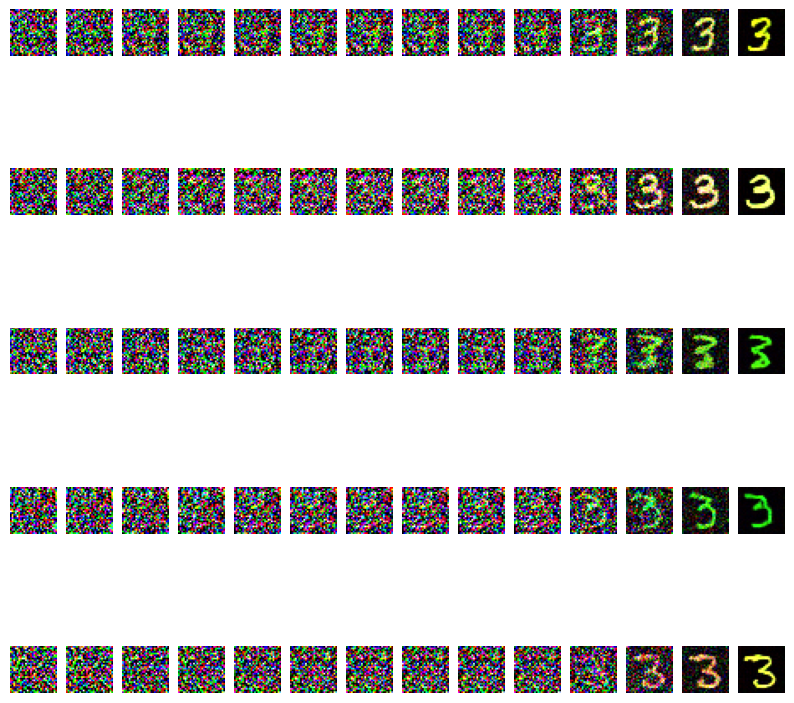

In [23]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

### Exponential integrator

In [33]:
n_images = 2

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=1,
    device=torch.device("cuda")
)
T_tensor = torch.tensor([T], device=device)

times, synthetic_images_t = exponential_integrator(
    x_0=image_T,
    t_0=T,
    t_end=1e-3,
    n_steps=2000,
    drift_linear_coeff=lambda t: 0.5 * diffusion_process.beta(t),
    diffusion_coefficient=diffusion_coefficient,
    score_function=score_model,
)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 3.12 MiB is free. Including non-PyTorch memory, this process has 3.80 GiB memory in use. Of the allocated memory 3.71 GiB is allocated by PyTorch, and 16.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [28]:
print(type(synthetic_images_t))
print(synthetic_images_t.shape)

<class 'torch.Tensor'>
torch.Size([2, 3, 28, 28, 501])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7610428..3.5460217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.071473..3.814926].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-40.92507..28.469414].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-71.68264..48.00212].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-101.1471..65.86436].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-113.42161..72.98615].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-117.67784..75.37

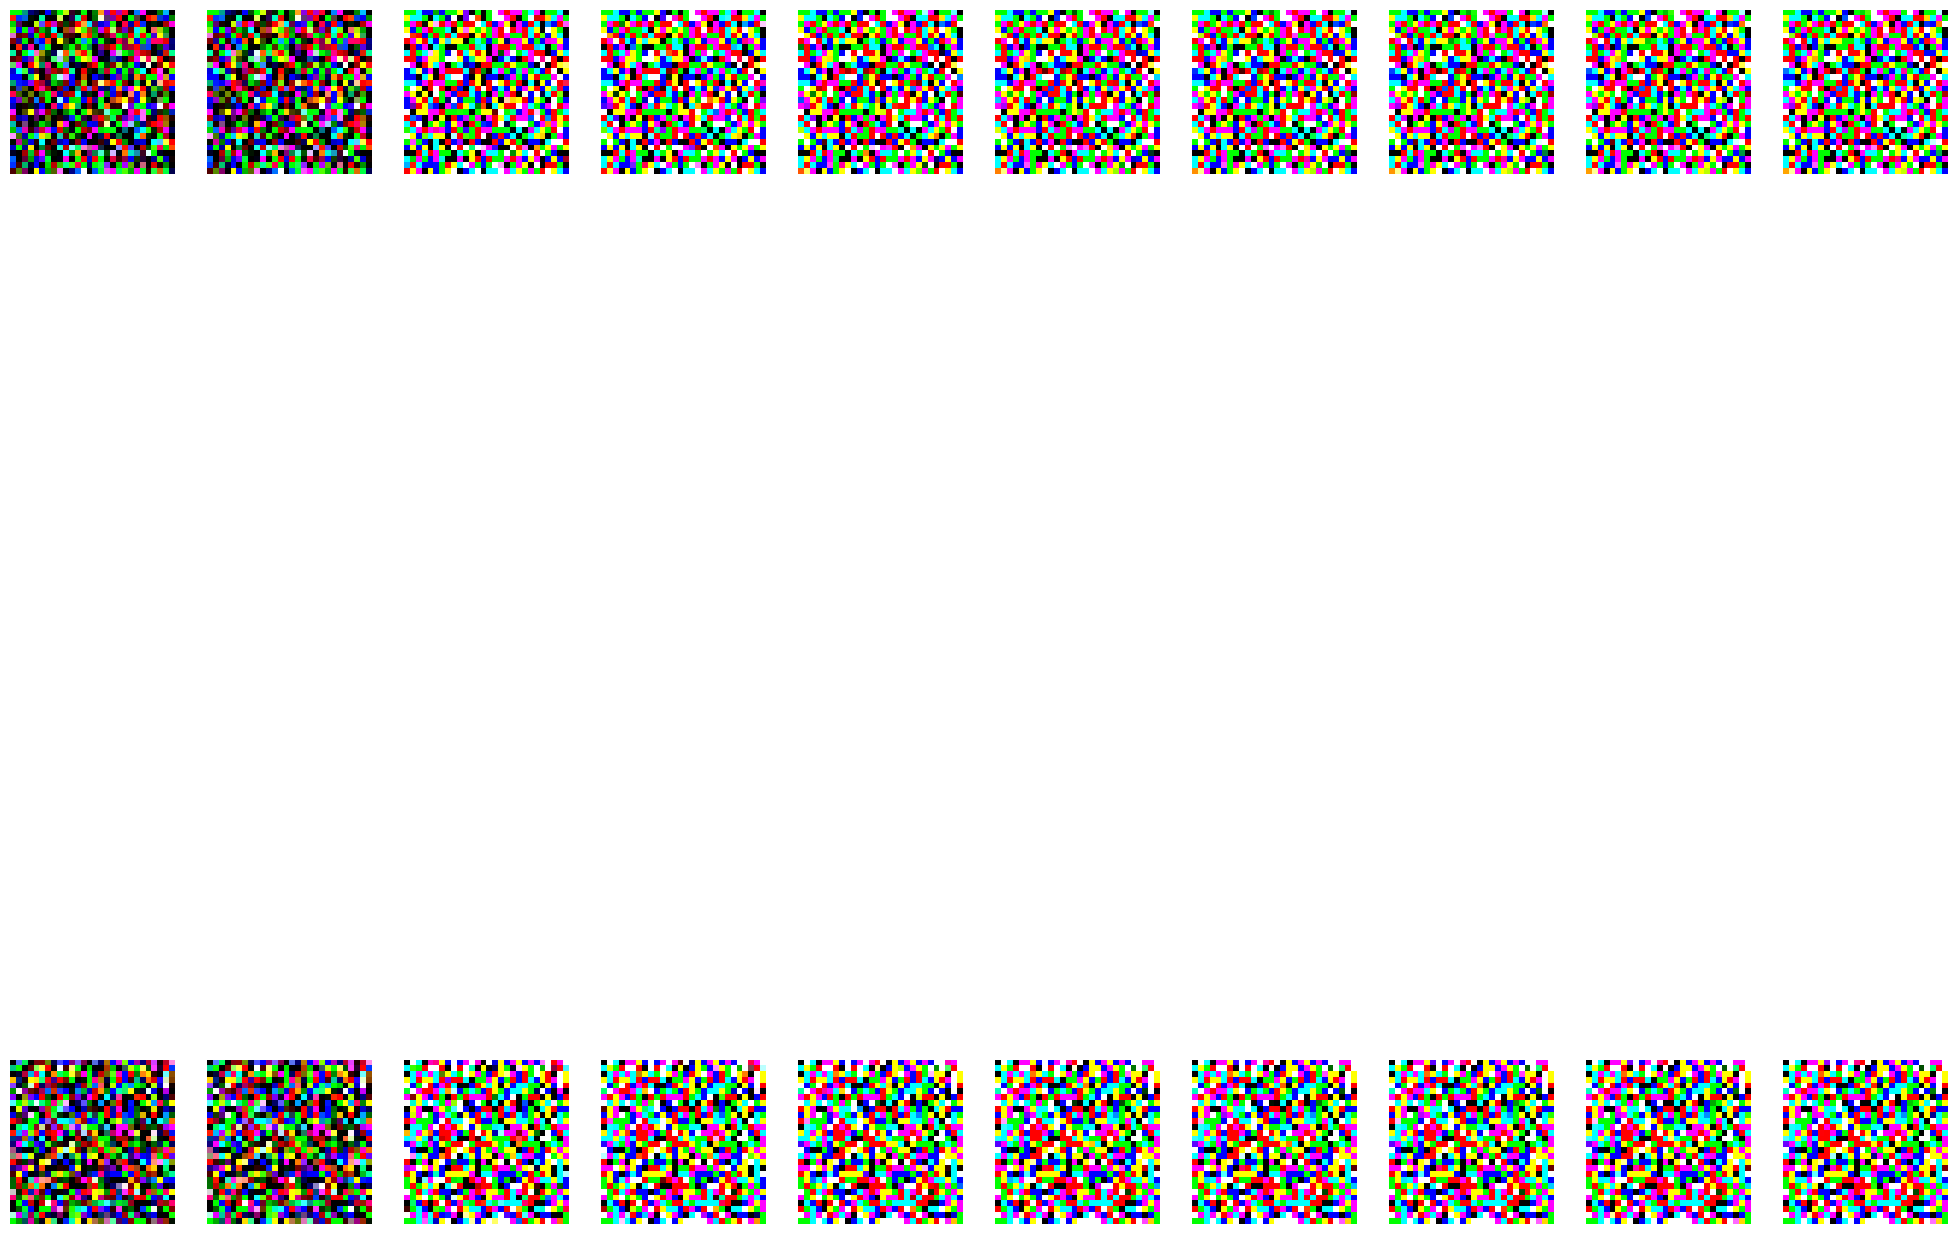

In [30]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.detach().cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500],
    figsize=(25, 25),
)